In [48]:
# Library import code from book
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Personal imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import datetime

from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

In [49]:
if torch.cuda.is_available():
    # Create a device object for the GPU
    device = torch.device('cuda')
else:
    # Create a device object for the CPU
    device = torch.device('cpu')
device

device(type='cuda')

In [50]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

In [51]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

# Problem 2A: CNN with two hidden layers

Since MaxPool and Activation Function do not have parameters that need to be trained, the functional version of these elements will be used instead (where the outputs from each node layer will be passed into these functions).

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [56]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader,
                  train_loss, val_loss):
    timer_s = time.time()
    for epoch in range(0, n_epochs):
        loss_train = 0.0
        loss_val = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            t_loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            torch.cuda.empty_cache()
            t_loss.backward()
            optimizer.step()

            loss_train += t_loss.item()
            
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            v_loss = loss_fn(outputs, labels)
            
            loss_val += v_loss.item()
        
        train_loss.append(loss_train/len(train_loader))
        val_loss.append(loss_val/len(val_loader))
        
        if epoch % 30 == 0 or epoch == 299:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, loss_train / len(train_loader),
                loss_val/len(val_loader)))
    timer_e = time.time()
    train_time = timer_e - timer_s
    print("Training Time:", train_time, "seconds")

In [57]:
torch.cuda.empty_cache()
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                           shuffle=True)
model = Net()
model = model.to(device)

learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
# optimizer = optimizer.to(device)
loss_fn = loss_fn.to(device)

train_loss = []
val_loss = []

In [58]:
training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    train_loss = train_loss,
    val_loss = val_loss
)

Epoch 0, Training loss 2.2831570303348627, Validation loss 2.243882756324331
Epoch 30, Training loss 1.5458097459410158, Validation loss 1.531758727541395
Epoch 60, Training loss 1.3636351297883427, Validation loss 1.3613317848011186
Epoch 90, Training loss 1.2277369410790446, Validation loss 1.2398202043430062
Epoch 120, Training loss 1.1006188426938508, Validation loss 1.124895600376615
Epoch 150, Training loss 1.0229382665870745, Validation loss 1.067679418500062
Epoch 180, Training loss 0.9690379347185345, Validation loss 1.01651333623631
Epoch 210, Training loss 0.9313014038383504, Validation loss 1.029131023367499
Epoch 240, Training loss 0.9020522409082984, Validation loss 0.9790690886746546
Epoch 270, Training loss 0.8769501789146678, Validation loss 0.9634382793098498
Epoch 299, Training loss 0.857290778280524, Validation loss 0.9641073258819094
Training Time: 5524.452919244766 seconds


In [59]:
torch.save(model.state_dict(), 'CIFAR10_1LayerCNN.pt')

In [61]:
torch.cuda.empty_cache()

In [ ]:
# Plot Training and Validation Loss over epochs
plt.figure(1)
plt.plot(range(n_epochs), train_loss, 'g')
plt.plot(range(n_epochs), val_loss, 'b')
plt.title("Loss vs epochs")
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()

In [64]:
# Training Accuracy
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                           shuffle=False)
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())
        
print("Training Accuracy: %f" % (train_correct / train_total))

# Validation Accuracy
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                           shuffle=False)
val_correct = 0
val_total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())
        
print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 0.696000
Validation Accuracy: 0.662900


# Problem 2B: CNN with an additional layer

In [80]:
class Net_3conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 64 * 4 * 4)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [81]:
torch.cuda.empty_cache()
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                           shuffle=True)
model_3conv = Net_3conv().to(device)

learning_rate = 1e-3
optimizer = optim.SGD(model_3conv.parameters(), lr=learning_rate)
loss_fn_3 = nn.CrossEntropyLoss()
# optimizer = optimizer.to(device)
loss_fn_3 = loss_fn_3.to(device)

train_loss_3conv = []
val_loss_3conv = []

In [82]:
training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model_3conv,
    loss_fn = loss_fn_3,
    train_loader = train_loader,
    val_loader = val_loader,
    train_loss = train_loss_3conv,
    val_loss = val_loss_3conv
)

Epoch 0, Training loss 2.2983914491770516, Validation loss 2.284728853565872
Epoch 30, Training loss 1.5436920279737019, Validation loss 1.5278783171040238
Epoch 60, Training loss 1.2742418855657358, Validation loss 1.2689268831994123
Epoch 90, Training loss 1.098003488291255, Validation loss 1.1130929923361275
Epoch 120, Training loss 0.9730362661201936, Validation loss 1.004539734618679
Epoch 150, Training loss 0.8726362977796198, Validation loss 0.9264594536678047
Epoch 180, Training loss 0.792600735679002, Validation loss 0.8676711761268081
Epoch 210, Training loss 0.7288371145039263, Validation loss 0.8315076888746517
Epoch 240, Training loss 0.6752930858251079, Validation loss 0.8096057506883221
Epoch 270, Training loss 0.6288914327578776, Validation loss 0.7833951705959952
Epoch 299, Training loss 0.5890144555617476, Validation loss 0.7769650934608119
Training Time: 5670.2540946006775 seconds


In [83]:
torch.save(model_3conv.state_dict(), 'CIFAR10_3LayerCNN.pt')

In [84]:
torch.cuda.empty_cache()

In [86]:
# Training Accuracy
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,
                                           shuffle=False)
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        outputs = model_3conv(imgs)
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())
        
print("Training Accuracy: %f" % (train_correct / train_total))

# Validation Accuracy
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
                                           shuffle=False)
val_correct = 0
val_total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        outputs = model_3conv(imgs)
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())
        
print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 0.800320
Validation Accuracy: 0.730200


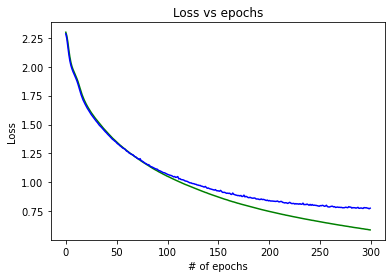

In [87]:
# Plot Training and Validation Loss over epochs
plt.figure(1)
plt.plot(range(n_epochs), train_loss_3conv, 'g')
plt.plot(range(n_epochs), val_loss_3conv, 'b')
plt.title("Loss vs epochs")
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()